## Notebook intended to be used for the initial steps of parameterizing a P-L system using openff-toolkit

This is the very basic first steps notebook, herein we shall:

1) Copy rcsb structure file over to this directory

2) Extract ligand from structure using pymol

3) Correct ligand bond orders from extracted pdb using rdkit and then save to sdf

4) Basic preparation of protein using pdbfixer to fill in any missing sidechains

5) Cap termini of protein

6) confirm prepared protein structure runs through tleap successfully

In [1]:
####################Import Block#########################
##General imports:
from pathlib import Path ##to use in defining paths and what not
import glob ##glob for globbing files
import os ##os for system commands
import shutil ##moving files
##CADD things:
from pymol import cmd  ##pymol for manipulating structures
from rdkit import Chem ##Chem module of rdkit for interacting with small molecules
from rdkit.Chem import AllChem ##Allchem has the methods for handling bond orders needed
from pdbfixer import PDBFixer ## pdbfixer is a command line tool for fixing rcsb structure issues
from openmm.app import PDBFile
####################Import Block#########################

In [2]:
## Set working directory
current_dir = Path().absolute()
print(current_dir)

/home/sramsey/Gits/Protein-Ligand-Build/example1


In [3]:
## Set directory where input file starts
input_dir = Path('/home/sramsey/Gits/Protein-Ligand-Build/raw_input')
print(input_dir)

/home/sramsey/Gits/Protein-Ligand-Build/raw_input


In [4]:
## generate list of input structures in your input directory
structures = glob.glob(str(input_dir) + '/*.pdb')
structures

['/home/sramsey/Gits/Protein-Ligand-Build/raw_input/5bt3.pdb']

In [5]:
structures[0]

'/home/sramsey/Gits/Protein-Ligand-Build/raw_input/5bt3.pdb'

In [6]:
##copy file to working directory
shutil.copy(structures[0], str(current_dir / '5bt3.pdb'))

'/home/sramsey/Gits/Protein-Ligand-Build/example1/5bt3.pdb'

In [7]:
ls

0-PrepareStructures.ipynb   5bt3_fixed4.pdb    leap.log    xtal_ligand.pdb
1-openff_systembuild.ipynb  5bt3_fixed.pdb     ligand.sdf
5bt3_fixed2.pdb             5bt3.pdb           README.md
5bt3_fixed3.pdb             5bt3_prepared.pdb  tleap.in


from https://www.rcsb.org/structure/5bt3 the ligand resname is 2LO

https://www.rcsb.org/ligand/2LO

inchikey: 	GEPYBHCJBORHCE-SFHVURJKSA-N

isomeric smiles:	"Cc1c(c(on1)C)c2ccc3c(c2)nc(n3C[C@H](C)N4CCOCC4)CCc5ccc(c(c5)Cl)OC"

In [8]:
##extract ligand from 5bt3.pdb original
cmd.reinitialize() #start new pymol session (command line)
cmd.load('5bt3.pdb') ##load file
cmd.select('ligand', 'resn 2LO') #select resname 2LO in object named ligand
cmd.save('xtal_ligand.pdb','ligand')

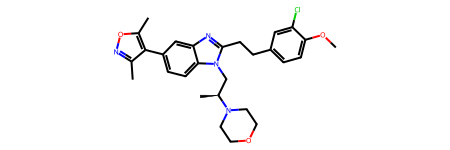

In [9]:
##correct bond orders of ligand using rdkit and the smiles from https://www.rcsb.org/ligand/2LO
ligand = 'xtal_ligand.pdb'
corrected_ligand = 'ligand.sdf'
smiles = 'Cc1c(c(on1)C)c2ccc3c(c2)nc(n3C[C@H](C)N4CCOCC4)CCc5ccc(c(c5)Cl)OC'
template = Chem.MolFromSmiles(smiles) ##create chem object based on smiles string
template ##view ligand from smiles

In [10]:
rawMol = AllChem.MolFromPDBFile(ligand) #load ligand from xtal
corMol = AllChem.AssignBondOrdersFromTemplate(template, rawMol) #apply bond orders from template to xtal
corMol_H = Chem.AddHs(corMol, addCoords=True) #add hydrogens
Chem.MolToMolFile(corMol_H, corrected_ligand) #save file as sdf

[11:42:18] WARNING: More than one matching pattern found - picking one



### Protein steps now

Before we start to prepare a protein structure there are a few preliminary steps to perform:

1) Visualize the protein in pymol, with particular focus on binding site and sequence in xtal

2) Check the header file of your structure to find relevant metadata

i) Missing Residues section (line 289 here in 5bt3.pdb)
  
ii) Missing atoms (no separate section here in 5bt3.pdb)
  
iii) SEQRES which defines the sequence as will be prepared by pdbfixer
  
3) Decide if you want to add missing residues or not. In this case (5bt3) the missing residues are two residues on the N termini which are...unimportant for us so we will not add those back on

pdbfixer command line example command

pdbfixer 5bt3.pdb --output=5bt3_fixed.pdb --add-atoms=all --replace-nonstandard --keep-heterogens=water

In [11]:
fixer = PDBFixer(filename='5bt3.pdb')
fixer.findNonstandardResidues() #check for modded amino acids
fixer.replaceNonstandardResidues() #replace nonstandards with equivalent standard residues
fixer.removeHeterogens(True) #remove heterogens removes all non protein, 'TRUE' here says to keepwater, 'FALSE' to delete water too
# fixer.findMissingResidues()
# fixer.findMissingAtoms()
# fixer.addMissingAtoms()
# previous lines are omitted here since we are not missing atoms and do not want to add the missing residues in our example structure
fixer.addMissingHydrogens(7.0) #option is for pH
PDBFile.writeFile(fixer.topology, fixer.positions, open('5bt3_fixed2.pdb', 'w'))

### Finalize protein preparatory steps

At this stage the protein file is at least nominally ready for simulations in that:

1) it is protonated

2) missing residues/atoms added

3) removed heterogens other than water

What remains to be done is to add capping residues to the protein if desired to neutralize the two termini and this process is pretty annoying to execute by command line, but possible

### Adding caps to termini

So typically when simulating protein systems in explicit solvent (or generally, really) it is best to cap the termini. These caps are uncharged modified residues that replace the otherwise charged N and C termini. Uncapped termini are not necessarily 'wrong' or 'bad', but since we are not often interested in interactions formed or maintained by the charges that would be otherwise modelled onto these termini it is usually recommended to replace the charged termini with the capping residues.

To this end you have several options as a modeller, you can use spruce or maestro tools for protein preparation to perform previous steps in this notebook (such as protonation and filling in missing atoms/residues) and indeed those software suites will also assist in capping your termini. 

But you can also do this yourself 'manually' so to speak. 

Manual action here requires editing the terminal residues such that when the structure is fed through tleap it will complete the template of the capped residues for you. To this end you should familiarize yourself with the residue template library within tleap:

AMBERHOME/dat/leap/lib/aminont12.lib and AMBERHOME/dat/leap/lib/aminoct12.lib, respectively. For reference standard amino acid residues can be seen in AMBERHOME/dat/leap/lib/amino12.lib (or a later version if you so desire).

In [12]:
'''
!entry.ACE.unit.atoms table  str name  str type  int typex  int resx  int flags  int seq  int elmnt  dbl chg
 "H1" "HC" 0 1 131072 1 1 0.112300
 "CH3" "CT" 0 1 131072 2 6 -0.366200
 "H2" "HC" 0 1 131072 3 1 0.112300
 "H3" "HC" 0 1 131072 4 1 0.112300
 "C" "C" 0 1 131072 5 6 0.597200
 "O" "O" 0 1 131072 6 8 -0.567900
'''

'''
!entry.NME.unit.atoms table  str name  str type  int typex  int resx  int flags  int seq  int elmnt  dbl chg
 "N" "N" 0 1 131072 1 7 -0.415700
 "H" "H" 0 1 131072 2 1 0.271900
 "C" "CT" 0 1 131072 3 6 -0.149000
 "H1" "H1" 0 1 131072 4 1 0.097600
 "H2" "H1" 0 1 131072 5 1 0.097600
 "H3" "H1" 0 1 131072 6 1 0.097600
'''

print('Idk just for formatting -- but these are the atom entries in the above listed library files')
print('')
print('What we need to do is to identify what are our desired terminal residues and to rename them and their heavy atoms appropriately. Delete the hydrogens on these.')

Idk just for formatting -- but these are the atom entries in the above listed library files

What we need to do is to identify what are our desired terminal residues and to rename them and their heavy atoms appropriately. Delete the hydrogens on these.


The easiest way to accomplish this is to alter the structure in pymol. Before we do anything in code take the time to visualize the structure in pymol and consider the termini (residue numbers in particular) but also their relative positions (should we be concerned with clashes or any other abberations?)

In this structure example p300 (5bt3.pdb) the two termini ILE1 and GLY114 here are sort of nearby each other, but are fully solvent exposed so we can act with impunity when replacing them.

So this is going to be replacing the O,C,CA atoms of ILE1 with O,C,CH3 atoms of our new ACE1

And N,CA atoms of GLY114 with N,C atoms of NME114

Finally after we make these adjustments we should run the structure through tleap to confirm that everything works...and then be sure to remove errant TER flags that will attempt to separate the caps from the protein (in terms of chain id)

In [13]:
###okay enough discussion lets implement it!
Nterm = 1 #variables for terminal identification
Cterm = 114 #variables for terminal identification

cmd.reinitialize() #start a new pymol session -- good idea to do this everytime
cmd.load('5bt3_fixed2.pdb')
#store atoms to delete in pymol objects:
cmd.select('N-termini-remove', f'resi {Nterm} and polymer.protein and not name CA+C+O')
cmd.select('C-termini-remove', f'resi {Cterm} and polymer.protein and not name CA+N')
#in these commands the 'f' before the string enables formatting of bracketted variables
### easy way to insert variables into whatever, in this case strings but could be other formats
cmd.remove('N-termini-remove') #delete atoms
cmd.remove('C-termini-remove') #delete atoms
cmd.alter(f'resi {Nterm} and polymer.protein', 'resn="ACE"') #alter selection with alterations specified in second argument
cmd.alter(f'resi {Cterm} and polymer.protein', 'resn="NME"')
cmd.alter(f'resi {Nterm} and polymer.protein and name CA', 'name="CH3"')
cmd.alter(f'resi {Cterm} and polymer.protein and name CA', 'name="C"')
cmd.save('5bt3_fixed3.pdb', 'all')

### Visualize your intermediate creations at every step!!! Especially when implementing a workflow for the first time or on any system for which you have time to scrutinize (which should be most of them lets be honest)

### And now for the final step! tleap to check that our protein structure works and to save the processed structure (such that it will contain all the capping atoms)

After this step we will need to edit our final pdb file from these results, making sure to remove any TER's added unnecessarily. Didn't happen to me here but if it does add a TER between ACE or NME and the rest of the structure please delete it before using the structure in subsequent works.


Every facet of pdb file formatting is important to ensure our final simulation system is exactly as desired.

In [14]:
#write our tleap input file from our python script
with open('tleap.in','w') as file:
    l1 = "source leaprc.protein.ff14SB\n"
    l2 = "source leaprc.water.tip3p\n" ##needed since we include xtal waters
    l3 = "protein = loadpdb 5bt3_fixed3.pdb\n" #loading and saving is enough to add our atoms
    l4 = "savepdb protein 5bt3_fixed4.pdb\n"
    l5 = "quit"
    file.writelines([l1, l2, l3, l4, l5])
    
os.system("tleap -f tleap.in") #run tleap from our python script

-I: Adding /home/sramsey/miniconda3/envs/openff_2/dat/leap/prep to search path.
-I: Adding /home/sramsey/miniconda3/envs/openff_2/dat/leap/lib to search path.
-I: Adding /home/sramsey/miniconda3/envs/openff_2/dat/leap/parm to search path.
-I: Adding /home/sramsey/miniconda3/envs/openff_2/dat/leap/cmd to search path.
-f: Source tleap.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleap.in
----- Source: /home/sramsey/miniconda3/envs/openff_2/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /home/sramsey/miniconda3/envs/openff_2/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /home/sramsey/miniconda3/envs/openff_2/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /home/sramsey/miniconda3/envs/openff_2/dat/leap/parm/frcmod.ff14SB
Reading force field modification type file (frcmod)
Reading title:
ff14SB protein backbone and sidechain parameters
Loading library: /home/sramsey/min

0

In [20]:
### Shoot one more thing! When we run tleap over our system we alter the chain id
## of everything. Well really we delete it.
### So before we move on we need to take a quick detour and alter our structure in pymol to address this


cmd.reinitialize()
cmd.load('5bt3_fixed4.pdb')
cmd.alter('resn WAT','chain="W"')
cmd.alter('polymer.protein or resn ACE+NME','chain="A"') #need to be explicit to include caps
#pymol treats caps as not protein by default :D
##ALSO since we will be adding solvent using PDBFixer in the next notebook
### PDBFixer thinks NME should be NMA so lets adjust that now
cmd.alter('resn NME','resn="NMA"')
cmd.save('5bt3_fixed5.pdb')

### Congratulations!! Now we have our protein and ligands prepared and ready for system building in openmm for simulations.

In [21]:
###TODO need to remove TER card added between protein and NMA when saving in pymol

os.system('cp 5bt3_fixed5.pdb 5bt3_prepared.pdb') #copying final file and renaming it from our temp suffix

0